# KALRNA: Scoring initial poses

## 1. Scoring 3D aligned structures (fragment-based approach)
To evaluate the quality of the alignments produced (see 20190626-KALRNA_genetate_initial_confs), two scores were used to compare the aligned conformations for each follow-up candidate to their respective hit molecule:
- SuCOS score: The SuCOS score is an open-source shape and chemical feature overlap metric
- Tanimoto shape similarity: This score compares the similarity in shape between two molecules

The best conformation for each score is taken as the best initial geometry guess for each candidate molecule.

The results, indicating the best conformation for each candidate molecule for both the 'surprise' and 'similar' sets are returned as a dictionary, which can be displayed and manipulated by pandas. The dictionary gives the best score for each of the two scores described, the conformer-containing sdf file, and the index of the molecule in the sdf file for both scores, so that the conformations can be easily accessed from the original aligned conformer sdf file

### Code (adapted from https://bitbucket.org/Susanhleung/sucos/src/master/calc_SuCOS.py):

In [6]:
import argparse, os, gzip
import glob
import operator
import numpy as np
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem, rdShapeHelpers
from rdkit.Chem.FeatMaps import FeatMaps
from rdkit import RDConfig
from rdkit.Chem import Draw
from joblib import Parallel, delayed
import multiprocessing

fdef = AllChem.BuildFeatureFactory(os.path.join(RDConfig.RDDataDir, 'BaseFeatures.fdef'))

fmParams = {}
for k in fdef.GetFeatureFamilies():
    fparams = FeatMaps.FeatMapParams()
    fmParams[k] = fparams

keep = ('Donor', 'Acceptor', 'NegIonizable', 'PosIonizable', 'ZnBinder',
        'Aromatic', 'Hydrophobe', 'LumpedHydrophobe')

def get_FeatureMapScore(small_m, large_m, score_mode=FeatMaps.FeatMapScoreMode.All):
    featLists = []
    for m in [small_m, large_m]:
        rawFeats = fdef.GetFeaturesForMol(m)
        # filter that list down to only include the ones we're intereted in
        featLists.append([f for f in rawFeats if f.GetFamily() in keep])
    fms = [FeatMaps.FeatMap(feats=x, weights=[1] * len(x), params=fmParams) for x in featLists]
    fms[0].scoreMode = score_mode
    fm_score = fms[0].ScoreFeats(featLists[1]) / min(fms[0].GetNumFeatures(), len(featLists[1]))
    return fm_score

def sucos_mol_to_mol(mol1, mol2, score_mode=FeatMaps.FeatMapScoreMode.All):
    ref = Chem.AddHs(mol1)
    prb = Chem.AddHs(mol2)
    
    fm_score = get_FeatureMapScore(ref, prb, score_mode)
    fm_score = np.clip(fm_score, 0, 1)

    protrude_dist = rdShapeHelpers.ShapeProtrudeDist(ref, prb,
            allowReordering=False)
    protrude_dist = np.clip(protrude_dist, 0, 1)

    SuCOS_score = 0.5*fm_score + 0.5*(1 - protrude_dist)
    
    return SuCOS_score


def score(ref_file, prb_file, score_mode=FeatMaps.FeatMapScoreMode.All, p=False):
    reflig = Chem.MolFromMolFile(ref_file, sanitize=True)
    ref = Chem.AddHs(reflig)
    prb_mols = Chem.SDMolSupplier(prb_file, sanitize=True)
    prb_mols = [x for x in prb_mols if x]
    idx = 0
    
    results_sucos = {}
    results_tani = {}
    
    smi_mol = Chem.MolToSmiles(prb_mols[0])
    
    for prb_mol in prb_mols:
        
        prb = Chem.AddHs(prb_mol)
                
        fm_score = get_FeatureMapScore(ref, prb, score_mode)
        fm_score = np.clip(fm_score, 0, 1)
        
        protrude_dist = rdShapeHelpers.ShapeProtrudeDist(ref, prb,
                allowReordering=False)
        protrude_dist = np.clip(protrude_dist, 0, 1)
        
        SuCOS_score = 0.5*fm_score + 0.5*(1 - protrude_dist)
        tanimoto_score = Chem.rdShapeHelpers.ShapeTanimotoDist(ref, prb)
        
        results_sucos[str(idx)] = SuCOS_score
        results_tani[str(idx)] = tanimoto_score
        
        if p:
        
            print ("********************************")
            print ("index: " + str(idx))
            print ("SuCOS score:\t%f" % SuCOS_score)
            print ("Tani score:\t%f" % tanimoto_score)
            print ("********************************")
        
        idx+=1

    return results_sucos, results_tani, smi_mol, prb_mols, reflig


def select_highest(results, number):
    ids = []
    r = results
    while len(ids)<number:
        i = max(results.items(), key=operator.itemgetter(1))[0]
        ids.append(int(i))
        r.pop(i, None)
    return ids

def select_lowest(results, number):
    ids = []
    r = results
    while len(ids)<number:
        i = min(results.items(), key=operator.itemgetter(1))[0]
        ids.append(int(i))
        r.pop(i, None)
    return ids

def score_all_confs(hit_file_directory, initial_hit, all_confs_paths):

    all_results_dict = {
        'candidate_name': [],
        'candidate_smiles': [],
        'candidate_conformers_file': [],
        'initial_hit': [],
        'best_sucos': [],
        'best_sucos_id': [],
        'best_tanimoto': [],
        'best_tanimoto_id': [],
    }
    
    for i in range(0, len(all_confs_paths)):
        results_sucos, results_tani, smiles, prb_mols, reflig = score(ref_file=initial_hit, prb_file=all_confs_paths[i])
        print('running ' + str(i) + '/' + str(len(all_confs_paths)))
        # best sucos socre and id
        r = results_sucos.copy()
        idx = select_highest(r, 1)[0]
        sucos_score = results_sucos[str(idx)]
        # best tanimoto socre and id
        s = results_tani.copy()
        idy = select_lowest(s, 1)[0]
        tani_score = results_tani[str(idy)]

        all_results_dict['candidate_name'].append(all_confs_paths[i].split('/')[-1].replace('_confs_aligned.sdf', ''))
        all_results_dict['candidate_smiles'].append(smiles)
        all_results_dict['candidate_conformers_file'].append(all_confs_paths[i])
        all_results_dict['initial_hit'].append(initial_hit.split('/')[-1])
        all_results_dict['best_sucos'].append(sucos_score)
        all_results_dict['best_sucos_id'].append(idx)
        all_results_dict['best_tanimoto'].append(tani_score)
        all_results_dict['best_tanimoto_id'].append(idy)

    return all_results_dict

In [7]:
hit_file_directory = '/Users/res3/michellab/XChem-examples/KALRNA/GDP_frags/GDP/'
initial_hit = '/Users/res3/michellab/XChem-examples/KALRNA/GDP_frags/GDP/GDP.sdf'
all_confs_paths = glob.glob(str(hit_file_directory + '*_confs_aligned.sdf'))

all_results_dict = score_all_confs(hit_file_directory=hit_file_directory, 
                                   initial_hit=initial_hit, 
                                   all_confs_paths=all_confs_paths)

running 0/1000
running 1/1000
running 2/1000
running 3/1000
running 4/1000
running 5/1000
running 6/1000
running 7/1000
running 8/1000
running 9/1000
running 10/1000
running 11/1000
running 12/1000
running 13/1000
running 14/1000
running 15/1000
running 16/1000
running 17/1000
running 18/1000
running 19/1000
running 20/1000
running 21/1000
running 22/1000
running 23/1000
running 24/1000
running 25/1000
running 26/1000
running 27/1000
running 28/1000
running 29/1000
running 30/1000
running 31/1000
running 32/1000
running 33/1000
running 34/1000
running 35/1000
running 36/1000
running 37/1000
running 38/1000
running 39/1000
running 40/1000
running 41/1000
running 42/1000
running 43/1000
running 44/1000
running 45/1000
running 46/1000
running 47/1000
running 48/1000
running 49/1000
running 50/1000
running 51/1000
running 52/1000
running 53/1000
running 54/1000
running 55/1000
running 56/1000
running 57/1000
running 58/1000
running 59/1000
running 60/1000
running 61/1000
running 62/1000
ru

running 489/1000
running 490/1000
running 491/1000
running 492/1000
running 493/1000
running 494/1000
running 495/1000
running 496/1000
running 497/1000
running 498/1000
running 499/1000
running 500/1000
running 501/1000
running 502/1000
running 503/1000
running 504/1000
running 505/1000
running 506/1000
running 507/1000
running 508/1000
running 509/1000
running 510/1000
running 511/1000
running 512/1000
running 513/1000
running 514/1000
running 515/1000
running 516/1000
running 517/1000
running 518/1000
running 519/1000
running 520/1000
running 521/1000
running 522/1000
running 523/1000
running 524/1000
running 525/1000
running 526/1000
running 527/1000
running 528/1000
running 529/1000
running 530/1000
running 531/1000
running 532/1000
running 533/1000
running 534/1000
running 535/1000
running 536/1000
running 537/1000
running 538/1000
running 539/1000
running 540/1000
running 541/1000
running 542/1000
running 543/1000
running 544/1000
running 545/1000
running 546/1000
running 547/10

running 971/1000
running 972/1000
running 973/1000
running 974/1000
running 975/1000
running 976/1000
running 977/1000
running 978/1000
running 979/1000
running 980/1000
running 981/1000
running 982/1000
running 983/1000
running 984/1000
running 985/1000
running 986/1000
running 987/1000
running 988/1000
running 989/1000
running 990/1000
running 991/1000
running 992/1000
running 993/1000
running 994/1000
running 995/1000
running 996/1000
running 997/1000
running 998/1000
running 999/1000


### 1.1 Evaluating the scores of aligned conformers

The results dictionary from above can be displayed by pandas. Showing the resulting data, sorted on 'best_sucos' shows that (according to sucos) the molecules we have generated are very similar, in shape and feature, to the starting hit molecule.

We can also see that the majority of the top ranked compounds are from the 'similar' set - which is to be expected. To add some diversity to the molecules that will be investigated further, the two sets have been separated back out for analysis (and the results saved out as csv files so we can look again later).

In [8]:
import pandas as pd
# create dataframe from results of scoring alignments
df = pd.DataFrame.from_dict(all_results_dict)

# top 500 compounds from each search set(similar/surprise) and score(sucos/tanimoto)
best_sucos_similar = df[df['candidate_name'].str.contains("similar")].sort_values(by=['best_sucos'], ascending=False).head(500)
best_tanimoto_similar = df[df['candidate_name'].str.contains("similar")].sort_values(by=['best_tanimoto'], ascending=True).head(500)
# best_sucos_surprise = df[df['candidate_name'].str.contains("surprise")].sort_values(by=['best_sucos'], ascending=False).head(500)
# best_tanimoto_surprise = df[df['candidate_name'].str.contains("surprise")].sort_values(by=['best_tanimoto'], ascending=True).head(500)

# save the top 500 as csv files
# best_sucos_similar.to_csv('/Users/res3/michellab/XChem-examples/KALRNA/GDP_frags/GDP/500_similar_sucos.csv')
# best_tanimoto_similar.to_csv('/Users/res3/michellab/XChem-examples/KALRNA/GDP_frags/GDP/500_similar_tanimoto.csv')
# #best_sucos_surprise.to_csv('/Users/res3/michellab/XChem-examples/KALRNA/GDP_frags/GDP/500_surprise_sucos.csv')
# #best_tanimoto_surprise.to_csv('/Users/res3/michellab/XChem-examples/KALRNA/GDP_frags/GDP/500_surprise_tanimoto.csv')

# display results frame
df.sort_values(by=['best_sucos'], ascending=False)

,candidate_name,candidate_smiles,candidate_conformers_file,initial_hit,best_sucos,best_sucos_id,best_tanimoto,best_tanimoto_id
639,GDP-similar-rsn_349,CN(CC1COCCN1C(=O)c1nc(N)cc(=O)[nH]1)C(=O)CN(C)...,/Users/res3/michellab/XChem-examples/KALRNA/GD...,GDP.sdf,0.582254,82,0.390176,82
869,GDP-similar-rsn_457,Nc1nc2c(ncn2C2OC(CO)C(O)C2O)c(=O)[nH]1,/Users/res3/michellab/XChem-examples/KALRNA/GD...,GDP.sdf,0.566026,26,0.376557,26
768,GDP-similar-rsn_719,CN(C)S(=O)(=O)N(C)CC(=O)NCC1COCCN1C(=O)c1nc(N)...,/Users/res3/michellab/XChem-examples/KALRNA/GD...,GDP.sdf,0.563893,59,0.389107,41
871,GDP-similar-rsn_419,CN(C)S(=O)(=O)N(C)CC(=O)NC1COCCN(C(=O)c2nc(Cl)...,/Users/res3/michellab/XChem-examples/KALRNA/GD...,GDP.sdf,0.562815,77,0.419145,56
364,GDP-similar-rsn_810,COCCOCC(=O)NCC1COCCN1C(=O)c1nc(Cl)c(=O)[nH]c1N,/Users/res3/michellab/XChem-examples/KALRNA/GD...,GDP.sdf,0.561870,68,0.429469,69
343,GDP-similar-rsn_416,CNS(=O)(=O)NCC(=O)NCC1COCCN1C(=O)c1nc(Cl)c(=O)...,/Users/res3/michellab/XChem-examples/KALRNA/GD...,GDP.sdf,0.559714,71,0.412684,71
40,GDP-similar-rsn_10,CN(C)S(=O)(=O)CC(=O)NCC1CN(C(=O)c2nc(Cl)c(=O)[...,/Users/res3/michellab/XChem-examples/KALRNA/GD...,GDP.sdf,0.550521,56,0.408001,85
497,GDP-similar-rsn_925,CN(CC(=O)NCC1COCCN1C(=O)c1nc(Cl)c(=O)[nH]c1N)S...,/Users/res3/michellab/XChem-examples/KALRNA/GD...,GDP.sdf,0.549861,86,0.363360,45
468,GDP-similar-rsn_911,CCS(=O)(=O)N(C)CC(=O)NCC1COCCN1C(=O)c1nc(N)cc(...,/Users/res3/michellab/XChem-examples/KALRNA/GD...,GDP.sdf,0.548418,78,0.349908,16
723,GDP-similar-rsn_149,CS(C)(=O)=NS(=O)(=O)N1CCN(C(=O)Cn2cnc3c(=O)[nH...,/Users/res3/michellab/XChem-examples/KALRNA/GD...,GDP.sdf,0.548386,32,0.439853,33


### 1.2 Evaluating the diversity of the top-scoring candidates

Given the SuCos scores (and tanimoto scores) of the highest-scored compounds are extremely similar to each other (e.g. the top 14 compounds all have a SuCOS score of 0.98), it is likely that the compounds themselves are very similar to each other, and do not represent a chemically-diverse set.

To evaluate this, the sucos score for each of the top 500 compounds (scored with sucos) with every other compound  for both the similar and surprise sets was calculated

In [11]:
from rdkit.Chem.rdMolDescriptors import GetMorganFingerprint
from rdkit import DataStructs
from rdkit.SimDivFilters.rdSimDivPickers import MaxMinPicker

def mols_from_df(df, files_col='candidate_conformers_file', id_col='best_sucos_id'):
    mols = [Chem.SDMolSupplier(f)[int(idx)] for f, idx in [(df.iloc[i][files_col], 
                                                            df.iloc[i][id_col]) 
                                                           for i in range(0, len(df))]]
    return mols

def mols_from_morgan(mols, number):
    def distij(i,j,fps=fps):
        return 1-DataStructs.DiceSimilarity(fps[i],fps[j])
    
    fps = [GetMorganFingerprint(x,3) for x in mols]
    nfps = len(fps)
    picker = MaxMinPicker()
    pickIndices = picker.LazyPick(distij,nfps,number,seed=23)
    picks = [mols[x] for x in pickIndices]
    
    return picks, pickIndices

def compare_mols_sucos(df):
    mat = []
    i = 0
    for mol1 in df:
        print('eval mol ' + str(i))
        arr = []
        for mol2 in df:
            arr.append(sucos_mol_to_mol(mol1=mol1, mol2=mol2))
        mat.append(arr)
        i += 1
    return mat

In [12]:
top_500_similar_mols = mols_from_df(best_sucos_similar)
top_500_similar_mat = compare_mols_sucos(top_500_similar_mols)

eval mol 0
eval mol 1
eval mol 2
eval mol 3
eval mol 4
eval mol 5
eval mol 6
eval mol 7
eval mol 8
eval mol 9
eval mol 10
eval mol 11
eval mol 12
eval mol 13
eval mol 14
eval mol 15
eval mol 16
eval mol 17
eval mol 18
eval mol 19
eval mol 20
eval mol 21
eval mol 22
eval mol 23
eval mol 24
eval mol 25
eval mol 26
eval mol 27
eval mol 28
eval mol 29
eval mol 30
eval mol 31
eval mol 32
eval mol 33
eval mol 34
eval mol 35
eval mol 36
eval mol 37
eval mol 38
eval mol 39
eval mol 40
eval mol 41
eval mol 42
eval mol 43
eval mol 44
eval mol 45
eval mol 46
eval mol 47
eval mol 48
eval mol 49
eval mol 50
eval mol 51
eval mol 52
eval mol 53
eval mol 54
eval mol 55
eval mol 56
eval mol 57
eval mol 58
eval mol 59
eval mol 60
eval mol 61
eval mol 62
eval mol 63
eval mol 64
eval mol 65
eval mol 66
eval mol 67
eval mol 68
eval mol 69
eval mol 70
eval mol 71
eval mol 72
eval mol 73
eval mol 74
eval mol 75
eval mol 76
eval mol 77
eval mol 78
eval mol 79
eval mol 80
eval mol 81
eval mol 82
eval mol 83
ev

In [286]:
# top_500_surprise_mols = mols_from_df(best_sucos_surprise)
# top_500_surprise_mat = compare_mols_sucos(top_500_surprise_mols)

eval mol 0
eval mol 1
eval mol 2
eval mol 3
eval mol 4
eval mol 5
eval mol 6
eval mol 7
eval mol 8
eval mol 9
eval mol 10
eval mol 11
eval mol 12
eval mol 13
eval mol 14
eval mol 15
eval mol 16
eval mol 17
eval mol 18
eval mol 19
eval mol 20
eval mol 21
eval mol 22
eval mol 23
eval mol 24
eval mol 25
eval mol 26
eval mol 27
eval mol 28
eval mol 29
eval mol 30
eval mol 31
eval mol 32
eval mol 33
eval mol 34
eval mol 35
eval mol 36
eval mol 37
eval mol 38
eval mol 39
eval mol 40
eval mol 41
eval mol 42
eval mol 43
eval mol 44
eval mol 45
eval mol 46
eval mol 47
eval mol 48
eval mol 49
eval mol 50
eval mol 51
eval mol 52
eval mol 53
eval mol 54
eval mol 55
eval mol 56
eval mol 57
eval mol 58
eval mol 59
eval mol 60
eval mol 61
eval mol 62
eval mol 63
eval mol 64
eval mol 65
eval mol 66
eval mol 67
eval mol 68
eval mol 69
eval mol 70
eval mol 71
eval mol 72
eval mol 73
eval mol 74
eval mol 75
eval mol 76
eval mol 77
eval mol 78
eval mol 79
eval mol 80
eval mol 81
eval mol 82
eval mol 83
ev

In [283]:
top_500_similar_mat=mat

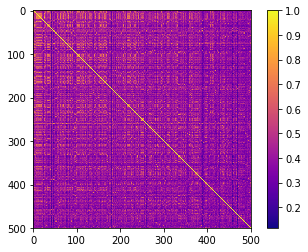

In [13]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
m = np.array(top_500_similar_mat)
plt.imshow(m, interpolation='nearest', cmap='plasma')
plt.colorbar()
plt.show()

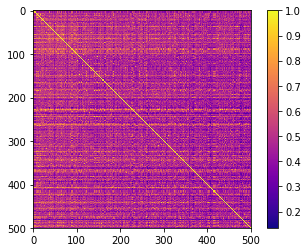

In [342]:
m = np.array(top_500_surprise_mat)
plt.imshow(m, interpolation='nearest', cmap='plasma')
plt.colorbar()
plt.show()

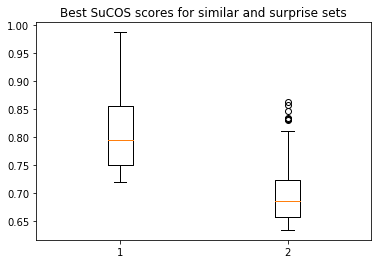

In [292]:
fig7, ax7 = plt.subplots()
ax7.set_title('Best SuCOS scores for similar and surprise sets')
ax7.boxplot([list(best_sucos_similar['best_sucos']), list(best_sucos_surprise['best_sucos'])])

plt.show()

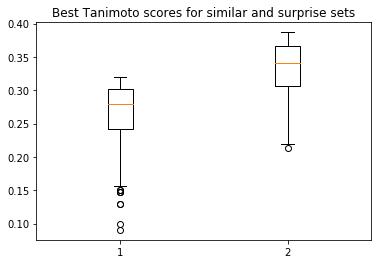

In [293]:
fig7, ax7 = plt.subplots()
ax7.set_title('Best Tanimoto scores for similar and surprise sets')
ax7.boxplot([list(best_tanimoto_similar['best_tanimoto']), list(best_tanimoto_surprise['best_tanimoto'])])

plt.show()

In [338]:
# top_250_similar_diverse, inds_250sd = mols_from_morgan(top_500_similar_mols, 250)  
df250 = best_sucos_similar.iloc[inds_250sd]

In [333]:
df = df250.sort_values(by=['best_sucos'], ascending=False)

df250_mols = mols_from_df(df)
top_250_similar_diverse_mat = compare_mols_sucos(df250_mols)

eval mol 0
eval mol 1
eval mol 2
eval mol 3
eval mol 4
eval mol 5
eval mol 6
eval mol 7
eval mol 8
eval mol 9
eval mol 10
eval mol 11
eval mol 12
eval mol 13
eval mol 14
eval mol 15
eval mol 16
eval mol 17
eval mol 18
eval mol 19
eval mol 20
eval mol 21
eval mol 22
eval mol 23
eval mol 24
eval mol 25
eval mol 26
eval mol 27
eval mol 28
eval mol 29
eval mol 30
eval mol 31
eval mol 32
eval mol 33
eval mol 34
eval mol 35
eval mol 36
eval mol 37
eval mol 38
eval mol 39
eval mol 40
eval mol 41
eval mol 42
eval mol 43
eval mol 44
eval mol 45
eval mol 46
eval mol 47
eval mol 48
eval mol 49
eval mol 50
eval mol 51
eval mol 52
eval mol 53
eval mol 54
eval mol 55
eval mol 56
eval mol 57
eval mol 58
eval mol 59
eval mol 60
eval mol 61
eval mol 62
eval mol 63
eval mol 64
eval mol 65
eval mol 66
eval mol 67
eval mol 68
eval mol 69
eval mol 70
eval mol 71
eval mol 72
eval mol 73
eval mol 74
eval mol 75
eval mol 76
eval mol 77
eval mol 78
eval mol 79
eval mol 80
eval mol 81
eval mol 82
eval mol 83
ev

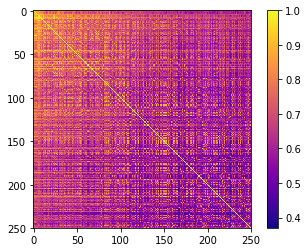

In [334]:
m = np.array(top_250_similar_diverse_mat)
plt.imshow(m, interpolation='nearest', cmap='plasma')
plt.colorbar()
plt.show()

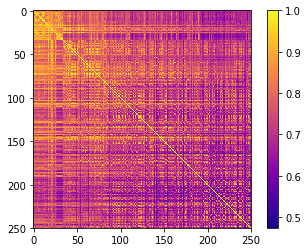

In [335]:
nl = []
for l in top_500_similar_mat[:250]:
    nl.append(l[:250])
m = np.array(nl)
plt.imshow(m, interpolation='nearest', cmap='plasma')
plt.colorbar()
plt.show()

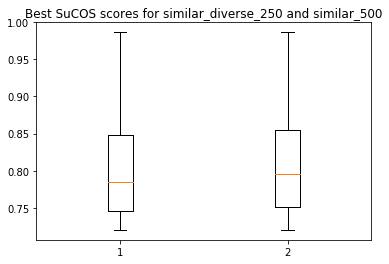

In [337]:
fig7, ax7 = plt.subplots()
ax7.set_title('Best SuCOS scores for similar_diverse_250 and similar_500')
ax7.boxplot([list(df['best_sucos']), list(best_sucos_similar['best_sucos'])])

plt.show()

In [348]:
best_sucos_surprise.iloc[:250].to_csv('/Users/res3/michellab/XChem-examples/KALRNA/XX02KALRNA-x1376_1/250_surprise_sucos.csv')

In [344]:
df.to_csv('/Users/res3/michellab/XChem-examples/KALRNA/XX02KALRNA-x1376_1/250_similar_sucos_diverse.csv')

In [346]:
writer = Chem.SDWriter('/Users/res3/michellab/XChem-examples/KALRNA/XX02KALRNA-x1376_1/250_similar_sucos_diverse.sdf')
for mol in df250_mols:
    writer.write(mol)

In [349]:
writer = Chem.SDWriter('/Users/res3/michellab/XChem-examples/KALRNA/XX02KALRNA-x1376_1/250_surprise_sucos.sdf')
for mol in top_500_surprise_mols[:250]:
    writer.write(mol)

In [9]:
best_tanimoto_similar

,candidate_name,candidate_smiles,candidate_conformers_file,initial_hit,best_sucos,best_sucos_id,best_tanimoto,best_tanimoto_id
568,GDP-similar-rsn_480,CN(C)[S@@](C)(=O)=NS(=O)(=O)N1CC(n2cnc3c(N)nc(...,/Users/res3/michellab/XChem-examples/KALRNA/GD...,GDP.sdf,0.498266,58,0.308493,58
272,GDP-similar-rsn_716,COCC(C)(O)C(=O)NCC1COCCN1C(=O)c1nc(N)cc(=O)[nH]1,/Users/res3/michellab/XChem-examples/KALRNA/GD...,GDP.sdf,0.503332,13,0.313108,56
818,GDP-similar-rsn_528,CN(CC(=O)NCC1COCCN1C(=O)c1nc(N)cc(=O)[nH]1)S(C...,/Users/res3/michellab/XChem-examples/KALRNA/GD...,GDP.sdf,0.536982,71,0.321554,15
279,GDP-similar-rsn_788,CC(C(=O)NCC1COCCN1C(=O)c1nc(N)cc(=O)[nH]1)S(N)...,/Users/res3/michellab/XChem-examples/KALRNA/GD...,GDP.sdf,0.493532,46,0.323561,80
774,GDP-similar-rsn_932,COCC(O)C(=O)NCC1COCCN1C(=O)c1nc(N)cc(=O)[nH]1,/Users/res3/michellab/XChem-examples/KALRNA/GD...,GDP.sdf,0.491385,84,0.330227,57
645,GDP-similar-rsn_403,CP(C)(=O)C(O)C(=O)NCC1COCCN1C(=O)c1nc(N)cc(=O)...,/Users/res3/michellab/XChem-examples/KALRNA/GD...,GDP.sdf,0.505651,58,0.335402,46
481,GDP-similar-rsn_269,CC(C)(CCS(=O)(=O)N1CC(n2cnc3c(N)nc(N)nc32)C1)S...,/Users/res3/michellab/XChem-examples/KALRNA/GD...,GDP.sdf,0.478874,96,0.335435,96
291,GDP-similar-rsn_174,CN(CC1COCCN1C(=O)c1nc(Cl)c(=O)[nH]c1N)C(=O)C(C...,/Users/res3/michellab/XChem-examples/KALRNA/GD...,GDP.sdf,0.482321,65,0.339241,0
883,GDP-similar-rsn_786,Nc1cc(=O)[nH]c(C(=O)N2CCOCC2CNC(=O)CCS(N)(=O)=...,/Users/res3/michellab/XChem-examples/KALRNA/GD...,GDP.sdf,0.516441,2,0.341361,30
668,GDP-similar-rsn_207,Nc1nc(N)c2ncn(C3CN(C(=O)CCc4nnn[n-]4)C3)c2n1,/Users/res3/michellab/XChem-examples/KALRNA/GD...,GDP.sdf,0.450635,95,0.342236,95


In [14]:
best_sucos_similar.to_csv('/Users/res3/michellab/XChem-examples/KALRNA/GDP_frags/GDP/500_similar_sucos.csv')
writer = Chem.SDWriter('/Users/res3/michellab/XChem-examples/KALRNA/GDP_frags/GDP/500_similar_sucos.sdf')
for mol in top_500_similar_mols:
    writer.write(mol)